In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# River chemistry data for the pan-Arctic

Aim: have monthly mean chemistry for big suite of chemical variables required by marine modellers, for all RADR catchments + Greenland, for the period 1980-2019

Approach:

1. Big 6 rivers: use observed data from Arctic-GRO

    Will probably need to do some patching and cleaning to get chem for the full period.To do:

    * Quick plot of time series to see how long the record is, gaps, etc. in each river
    * For rivers where there are big gaps, try to derive a regression with Q:
        * For the three sites where chemistry is measured a long way away from discharge, adjust the datetime by offsetting, so that the new timestamp matches the day when discharge is measured
        * For each chem variable, and for a variety of temporal aggregations (e.g. daily, monthly):
            * Plot QC
            * Plot logQ-logC
            * Fit linear regression. How good is regression? Get slope b. Value of b: dilution, mobilisation, static?
        * Use regressions with Q to derive daily or monthly concentration in each river for full baseline period.
    
    Will probably also use these regressions to predict the future, but first need to decide how to predict future changes in Q...


2. Predict water quality in the rest of the unmonitored AO

    How to do this?
    * Lit review. Catchment characteristics.
    * Focus in particular on DOC, DIC, Hg. Rest can be based on same methods used in A20 hindcast Andre and Phil did.

## User input

In [43]:
# Location of cleaned discharge data
q_cleaned_daily_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

in_chem_file = r'~/shared/pan_arctic_data/water_quality/ArcticGRO/ArcticGRO Water Quality Data_2022-02.xlsx'
out_folder = r'../output/qc_regressions/'

## Read in chem data

In [44]:
xl = pd.ExcelFile(in_chem_file)
rivers_li = xl.sheet_names[:-1]
rivers_li

['Ob', 'Yenisey', 'Lena', 'Kolyma', 'Yukon', 'Mackenzie']

In [45]:
chem_dict = {}  # key: river name (from rivers_li)

for river in rivers_li:
    df = pd.read_excel(in_chem_file, sheet_name=river, header=8, index_col=2,
                       skiprows=[9], parse_dates=True)

    # Calculate DON (mg/l) and add to dataframe
    df['DON'] = df['TDN'] - (df['NO3'] + df['NH4'])/1000
    df.loc[df['DON'] < 0, 'DON'] = 0  # set any negative values to 0

    # Calculate DHP (dissolved hydrolysable P)
    df['DHP'] = df['TDP'] - df['PO4']
    df.loc[df['DHP'] < 0, 'DHP'] = 0  # set any negative values to 0

    # Add DOC:DON mass ratio and fix divide by zero issues
    df['DOC_DON'] = df['DOC']/df['DON']
    df.loc[~np.isfinite(df['DOC_DON']), 'DOC_DON'] = np.nan

    # Add Total Hg:DOC ratio
    df['THg_DOC'] = df['UTHg']/df['DOC']

    chem_dict[river] = df

chem_dict['Ob'].head()

,Phase,River,ID,Discharge,Temp,pH,Cond,Alk,A254,A375,...,Sample depth 2,TSS (2),POC (2),POC-13C (2),PON (2),PON-15N (2),DON,DHP,DOC_DON,THg_DOC
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-16,PARTNERS,Ob',NaN,31200.0,19.8,7.5,NaN,44.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.35812,NaN,30.660114,NaN
2004-04-05,PARTNERS,Ob',NaN,3553.0,-1.0,7.0,NaN,130.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.10139,NaN,54.245981,NaN
2004-06-15,PARTNERS,Ob',NaN,34500.0,10.5,7.7,NaN,32.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.23439,NaN,37.160288,NaN
2004-06-17,PARTNERS,Ob',NaN,34500.0,12.6,7.7,NaN,34.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.20965,NaN,41.545433,NaN
2004-07-28,PARTNERS,Ob',NaN,26000.0,20.0,7.5,NaN,38.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.42492,NaN,28.264144,NaN


In [46]:
chem_dict['Ob'].columns

Index(['Phase', 'River', 'ID', 'Discharge', 'Temp', 'pH', 'Cond', 'Alk',
       'A254', 'A375', 'A412', 'A420', 'A440', 'H2O-2H', 'H2O-18O', 'DOC',
       'DOC-13C', 'DOC-14C', 'DOC-fm', 'TDN', 'NO3', 'NH4', 'TDP', 'PO4',
       'SiO2', 'Na', 'K', 'Mg', 'Ca', 'As', 'Ba', 'Cl', 'SO4', 'Li', 'Rb',
       'Sr', 'U', 'F', 'UTHg', 'UMeHg', 'TSS', 'POC', 'POC-13C', 'POC-14C',
       'POC-fm', 'PON', 'PON-15N', 'Sample depth 1', 'TSS (1)', 'POC (1)',
       'POC-13C (1)', 'PON (1)', 'PON-15N (1)', 'Sample depth 2', 'TSS (2)',
       'POC (2)', 'POC-13C (2)', 'PON (2)', 'PON-15N (2)', 'DON', 'DHP',
       'DOC_DON', 'THg_DOC'],
      dtype='object')

# Read in discharge data

In [72]:
q_dict = {}

for river in rivers_li:
    if river == "Yenisey":  # Name used for chem data
        river2 = "Yenisei"  # Name used for discharge data
    else:
        river2 = river
    fpath = os.path.join(q_cleaned_daily_folder, "%s_daily_1980-2019.csv" % river2)
    q_df = pd.read_csv(fpath, index_col=0, parse_dates=True)
    q_dict[river] = q_df

q_dict['Ob'].head()

,discharge
date,
1980-01-01,7360.0
1980-01-02,7350.0
1980-01-03,7350.0
1980-01-04,7320.0
1980-01-05,7290.0


# Make dataset including chem and Q

To do this, first need to apply date offset to get chem data as seen at discharge stations. 3 rivers monitor discharge and chemistry in different places, so following method used by Holmes et al. (): Calculate lag time between the two sampling stations by assuming river velocities of 1.5 m/s. Therefore use measured concentrations and assume they were observed at downstream locations on day + lag. Work out lags to apply as follows:
* Lena: water chem is 520 m U/S of discharge. Lag of ~4 days. Add 4 days to the WQ dates.
* Yenisey: WQ is 250 km D/S of Q. Lag of ~-2 days. Subtract 2 days.
* Kolyma: WQ is 150 km D/S of Q. Lag of ~-1 day. Subtract 1 day.

Also add discharge data for sampling dates. The ArcticGRO water quality data includes discharge data already. This is usually the same as the ArcticGRO discharge data for the same date, but not always. Perhaps it is because of the data cleaning I did, or patching, or perhaps they made errors too. Either way, I will use my cleaned data as the basis, rather than the discharge data included with the chem data.

Also truncate to just the chem variables of interest.

In [73]:
# N.B. 'UMeHg' is also of interest, but for some reason there is no
# data for any site. Need to follow up.
# Have replaced TDN with DON, as TDN didn't show a relationship with Q
chem_vars = ['Alk', 'DOC',
             'DON', 'DOC_DON',
             'NO3', 'NH4',
             'TDP', 'PO4',
             'SiO2', 'UTHg', 'POC', 'PON']

lag_dict = {'Lena': 4,
            'Yenisey': -2,
            'Kolyma': -1}

chem_q_daily_dict = {}
chem_q_monthly_dict = {}

for river in rivers_li:
    chem_df = chem_dict[river].copy()

    # Drop unwanted cols
    chem_df = chem_df.loc[:, chem_vars]

    # Convert to daily frequency, in prep for time shift for some rivs, and converting
    # to monthly freq for all
    chem_df_daily = chem_df.asfreq('D')
    chem_df_daily = chem_df_daily.loc[:'2019-12-31']  # Truncate to period of interest

    # For some rivs, apply time shift so chem dates are on the day at which that water parcel
    # would be seen at the gauging station ('ish)
    if river in lag_dict.keys():
        chem_df_daily = chem_df_daily.shift(lag_dict[river])

    # Add discharge data to the chem data (from cleaned ArcticGRO discharge files,
    # rather than using the 'Discharge' column in the WQ data)
    chem_df_daily['Q'] = q_dict[river].loc[chem_df_daily.index]

    # Also calculate monthly mean discharge and chem
    chem_df_monthly = chem_df_daily.resample('M').agg(np.mean)

    # Drop rows where all are NaNs (i.e. drop the daily or monthly freq)
    chem_df_daily.dropna(subset=chem_df_daily.columns.difference(['Q']),
                         how="all", inplace=True)
    chem_df_monthly.dropna(subset=chem_df_monthly.columns.difference(['Q']),
                           how="all", inplace=True)

    # Add to dicts
    chem_q_daily_dict[river] = chem_df_daily
    chem_q_monthly_dict[river] = chem_df_monthly

# Check at Lena. DOC was 5.2 on 2003-08-12. Should now be 5.2 on 2003-08-16. Ok.
print("Check of offset at Lena:")
print(chem_q_daily_dict['Lena']['DOC'].head())

# Check new Q column is ok. Find: identical for US rivs, bit diff for Sib ones.
# So code is working ok.
# print(chem_q_daily_dict['Mackenzie'].loc[:, ['Discharge', 'Q']])
print("\n" "Check of daily data for Ob:")
print(chem_q_daily_dict['Ob'].head())

print("\n" "Check of monthly data for Ob:")
print(chem_q_monthly_dict['Ob'].head())

Check of offset at Lena:
Date
2003-08-16     5.20
2004-04-13     6.70
2004-06-09    14.81
2004-06-11    12.41
2004-08-23     6.70
Name: DOC, dtype: float64

Check of daily data for Ob:
              Alk    DOC      DON    DOC_DON     NO3     NH4    TDP  PO4  \
Date                                                                       
2003-07-16   44.9  10.98  0.35812  30.660114   49.02   42.86  59.80  NaN   
2004-04-05  130.6   5.50  0.10139  54.245981  189.09  669.52  15.24  NaN   
2004-06-15   32.9   8.71  0.23439  37.160288  147.07    8.54  29.57  NaN   
2004-06-17   34.4   8.71  0.20965  41.545433  173.68   16.67  29.57  NaN   
2004-07-28   38.4  12.01  0.42492  28.264144   11.21   13.87  52.33  NaN   

             SiO2  UTHg   POC     PON        Q  
Date                                            
2003-07-16   3.86   NaN  1.23  140.07  31200.0  
2004-04-05  19.11   NaN  1.12  120.46   3553.0  
2004-06-15   4.77   NaN  2.18  294.14  34500.0  
2004-06-17   4.92   NaN  2.28  282.94

# Explore QC relationships

## Time series

In [74]:
# Function to plot time series of chem and Q together for each river
def plot_timeseries(chem_var, rivers_li, chem_dict, q_dict):

    fig = plt.figure()

    for river in rivers_li:

        fig = plt.figure(figsize=(10, 5))

        # Plot chem data
        ax = fig.add_subplot()
        chem_df = chem_dict[river][chem_var]
        chem_df.plot(marker='o', color='k', linestyle='none', grid=True, ax=ax)
        ax.set_ylabel(chem_var)
        ax.set_xlabel("")
        ax.legend('Chem', loc='upper left')

        # Plot Q data
        ax2 = ax.twinx()
        q_df = q_dict[river].loc['2003-01-01':]
        q_df.plot(ax=ax2)
        ax2.set_ylabel('Q')
        ax2.legend('Q', loc='upper right')

        # Tidy
        plt.title("%s" % str(river))
        plt.tight_layout()
        plt.show()

        # plt.savefig(os.path.join(chem_graph_folder,
        #                          'raw_data_%s-%s_%s' % (st_yr, end_yr, str(site))))

<Figure size 432x288 with 0 Axes>

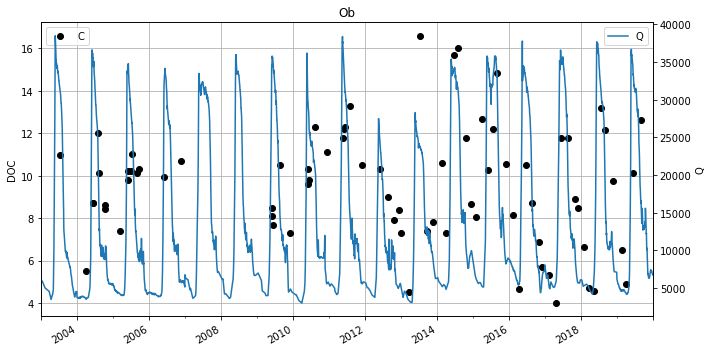

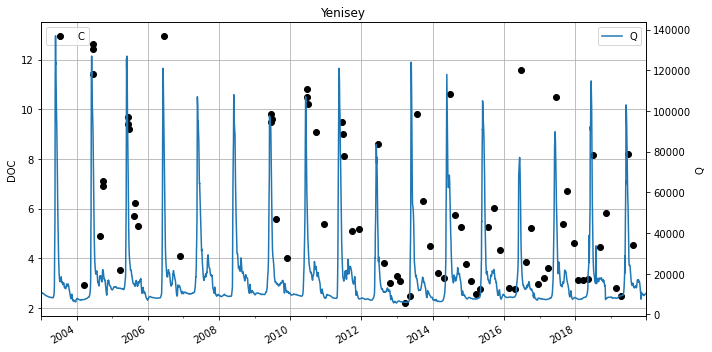

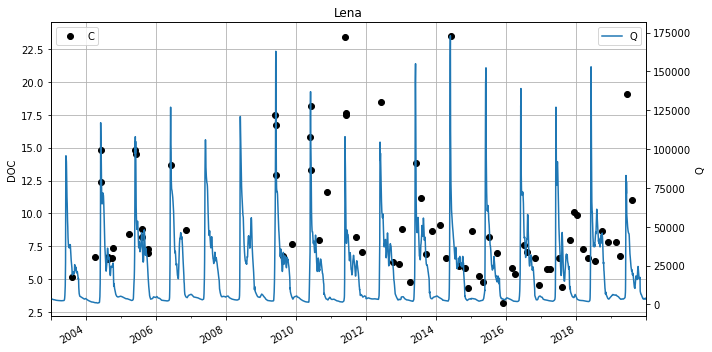

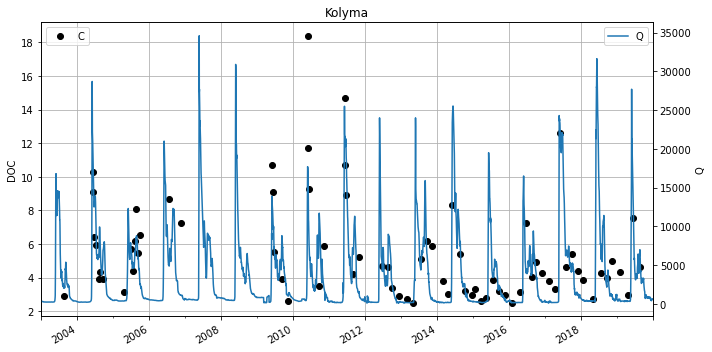

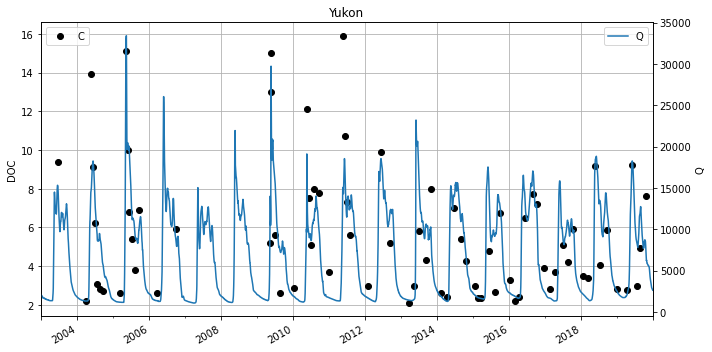

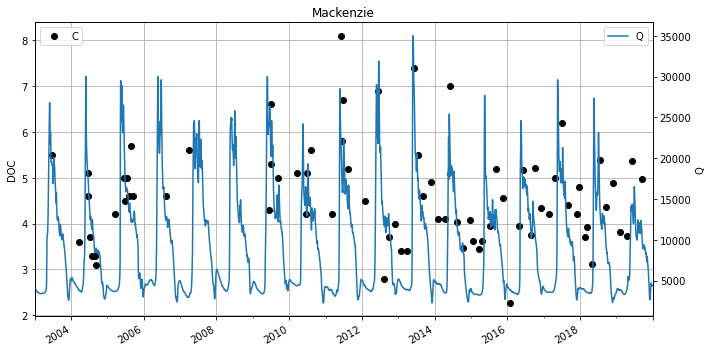

In [75]:
plot_timeseries('DOC', rivers_li, chem_dict, q_dict)

## Chem vs Q

In [129]:
def q_c_linear_regression(chem_q_dict, chem_var, out_folder,
                          log_q=False, log_chem=False,
                          monthly=False):
    """ """

    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    reg_dict = {}  # Key: river, returns sklearn linear regression model
    r2_s = pd.Series(dtype=np.float64)
    alpha_s = pd.Series(dtype=np.float64)

    for i, river in enumerate(rivers_li):
        df = chem_q_dict[river].loc[:, ["Q", chem_var]]
        # print(df.isnull().sum())  # 1 NA in DOC in Ob, Lena and Kolyma
        df = df.dropna()
        if len(df) < 20:
            continue  # i.e. don't do for this river, not enough data

        # If desired, log transform the data first
        if log_q is True:
            df["Q"] = np.log10(df["Q"])
            xlabel = "Log10 Q"
        else:
            xlabel = "Q"

        if log_chem is True:
            # To avoid log(0) errors, replace zeros with a small value
            # (1/200 of the mean). Or NaN
            # sub_value = df[chem_var].mean()/200
            sub_value = np.NaN
            df.loc[df[chem_var] == 0, chem_var] = sub_value
            df = df.dropna()
            # Then work out log
            df[chem_var] = np.log10(df[chem_var])
            # And set how the y-axis label will look
            ylabel = "Log10 %s" % chem_var
        else:
            ylabel = chem_var

        # Fit regression
        x = df["Q"].values.reshape((-1, 1))
        y = df[chem_var].values

        model = LinearRegression().fit(x, y)
        reg_dict[river] = model
        y_pred = model.predict(x)
        residuals = (y - y_pred)

        # To bias correct when back-transforming, calculate alpha
        alpha = np.exp(2.651*((residuals)**2).mean())
        alpha_s.loc[river] = alpha
        alpha_s.name = chem_var

        # Save regression results to a dataframe
        r_sq = model.score(x, y)
        r2_s.loc[river] = r_sq
        r2_s.name = chem_var
#         fit_c = model.intercept_
#         fit_m = model.coef_

#         # This results in a warning, but results are as desired, so supress warning
#         np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
#         linear_reg_df.loc[river, ["R2", "m", "c"]] = [r_sq, fit_c, fit_m]

        # Plot output of linear regression
        axs[i].scatter(x, y, color="black")
        axs[i].plot(x, y_pred, color="blue", linewidth=2)
        axs[i].set_xlabel(xlabel)
        if i == 0:
            axs[i].set_ylabel(ylabel)
        axs[i].set_title(river)

    plt.tight_layout()

    # Sort out file names and save
    if monthly is True:
        freq_str = "monthly"
    else:
        freq_str = "daily"

    # linear_reg_df.to_csv(
    #     os.path.join(
    #         out_folder,
    #         "qc_regression_%s_%s_logq-%s_logchem_%s.csv"
    #         % (chem_var, freq_str, log_q, log_chem),
    #     ),
    #     index_label="River",
    # )
    plt.savefig(
        os.path.join(
            out_folder,
            "qc_scatter_%s_%s_logq-%s_logchem_%s.png"
            % (chem_var, freq_str, log_q, log_chem),
        )
    )

    # print(linear_reg_df)
    return (reg_dict, r2_s, alpha_s)

({'Ob': LinearRegression(),
  'Yenisey': LinearRegression(),
  'Lena': LinearRegression(),
  'Kolyma': LinearRegression(),
  'Yukon': LinearRegression(),
  'Mackenzie': LinearRegression()},
 Ob           0.295192
 Yenisey      0.754356
 Lena         0.528598
 Kolyma       0.645068
 Yukon        0.635344
 Mackenzie    0.395186
 Name: DOC, dtype: float64,
 Ob           1.044607e+06
 Yenisey      3.713379e+02
 Lena         1.585761e+11
 Kolyma       5.815500e+03
 Yukon        5.461374e+04
 Mackenzie    6.195127e+00
 Name: DOC, dtype: float64)

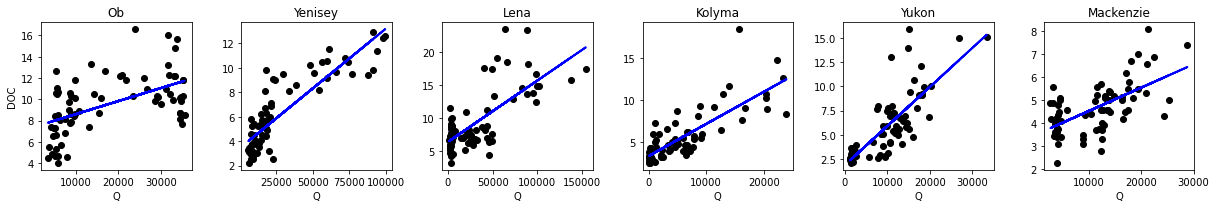

In [130]:
q_c_linear_regression(chem_q_daily_dict, 'DOC', out_folder)

### Loop through all chem vars and rivs and derive QC regression

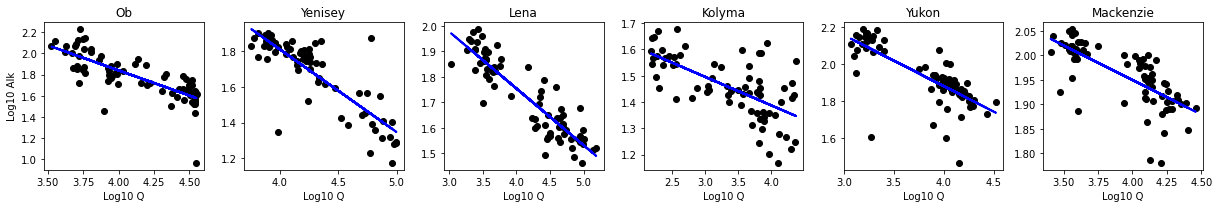

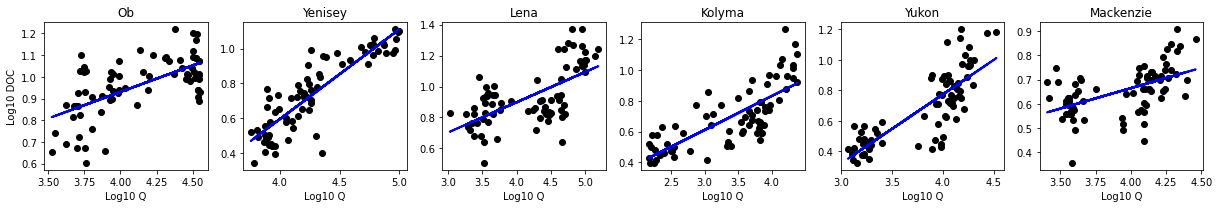

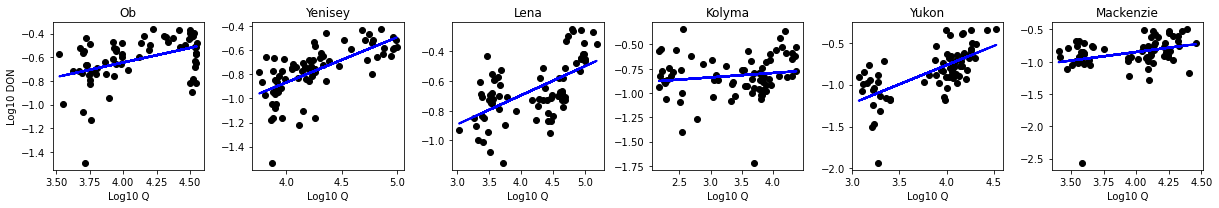

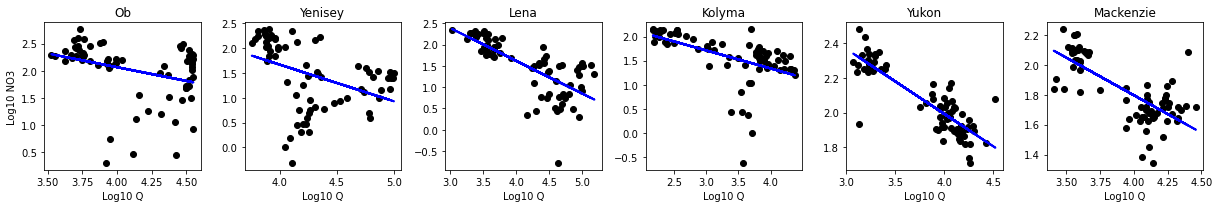

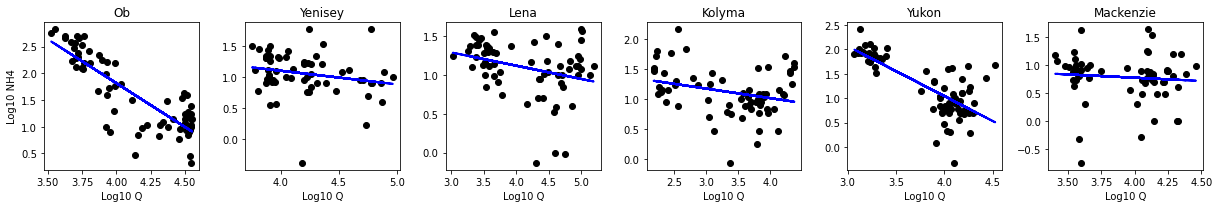

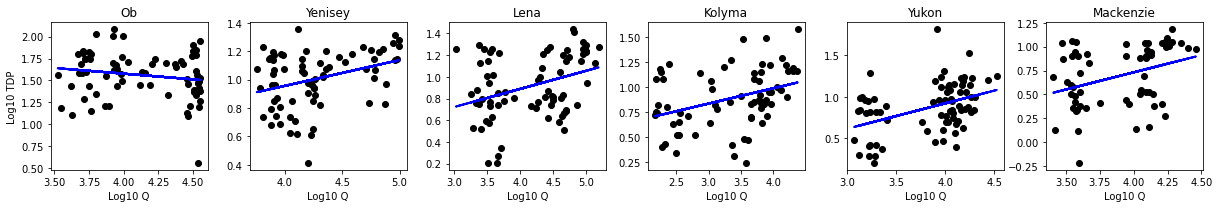

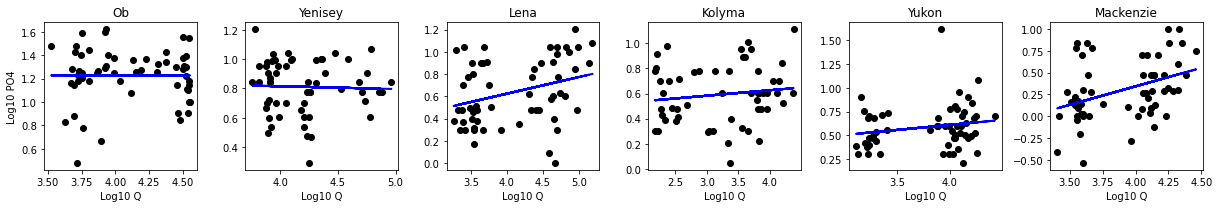

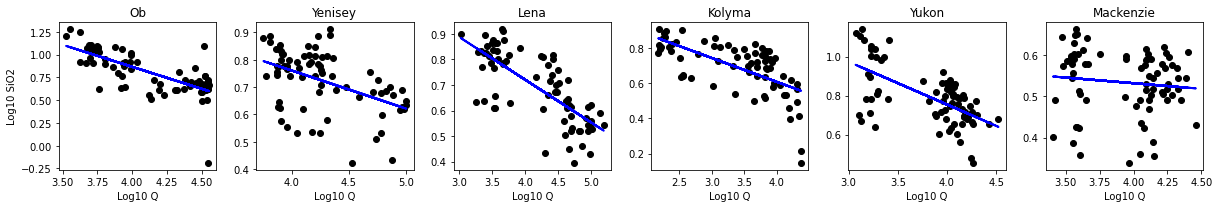

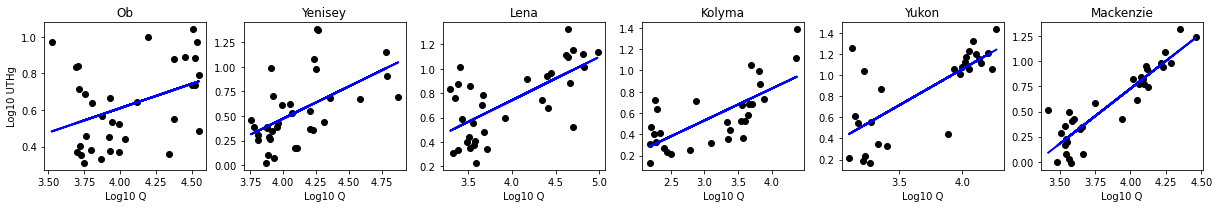

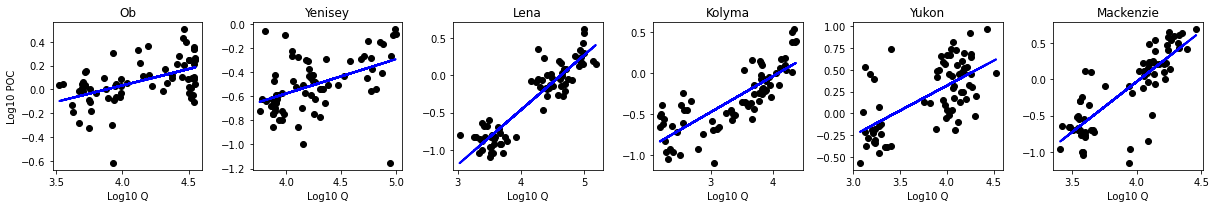

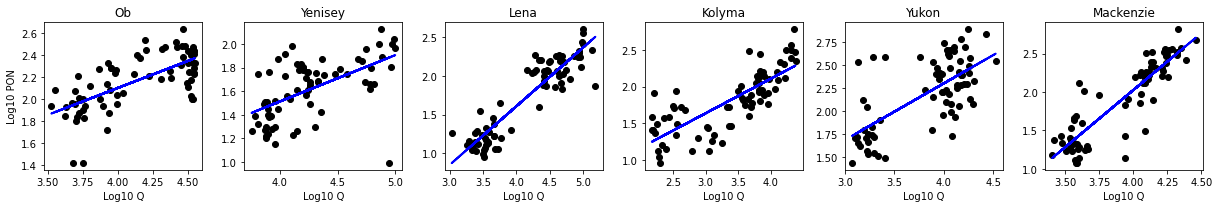

In [131]:
chem_vars_cq = [
    "Alk",
    "DOC",
    "DON",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]

# Key: chem_var, returns dict with key river, returns regression model.
reg_dict_untransf = {}
reg_dict_log = {}
r2_li = []
alpha_li = []

for chem_var in chem_vars_cq:
    reg_dict_log[chem_var], r2s, alphas = q_c_linear_regression(
        chem_q_daily_dict, chem_var, out_folder, log_chem=True, log_q=True
    )

    r2_li.append(r2s)
    alpha_li.append(alphas)

    # reg_dict_untransf[chem_var] = q_c_linear_regression(chem_q_daily_dict,
    #                                                     chem_var,
    #                                                     out_folder,
    #                                                     log_chem=False,
    #                                                     log_q=False)
    # q_c_linear_regression(chem_q_monthly_dict, chem_var, out_folder, monthly=True)

r2_df = pd.concat(r2_li, axis=1)
alpha_df = pd.concat(alpha_li, axis=1)

In [121]:
r2_df

,Alk,DOC,DON,NO3,NH4,TDP,PO4,SiO2,UTHg,POC,PON
Ob,0.610418,0.388704,0.181265,0.110573,0.712722,0.029346,0.000001,0.524009,0.151284,0.255959,0.455297
Yenisey,0.720334,0.765380,0.430886,0.163388,0.047441,0.114752,0.001177,0.215680,0.296045,0.206288,0.324481
Lena,0.816671,0.403097,0.349217,0.524695,0.090707,0.118611,0.096047,0.546998,0.441375,0.839452,0.840109
Kolyma,0.418333,0.587119,0.020946,0.268445,0.083170,0.135864,0.017139,0.411855,0.504940,0.646397,0.625637
Yukon,0.568962,0.646444,0.435838,0.734271,0.562577,0.177104,0.035163,0.390270,0.537848,0.402848,0.455564
Mackenzie,0.520751,0.278163,0.098478,0.536922,0.007314,0.118228,0.150572,0.011613,0.830754,0.673159,0.788250


In [132]:
alpha_df

,Alk,DOC,DON,NO3,NH4,TDP,PO4,SiO2,UTHg,POC,PON
Ob,1.046021,1.029904,1.088769,1.939229,1.420796,1.193131,1.148674,1.068614,1.117521,1.071411,1.093538
Yenisey,1.030681,1.029597,1.068688,2.783292,1.341988,1.095437,1.090786,1.025815,1.255280,1.113437,1.117456
Lena,1.010841,1.056864,1.071424,1.683897,1.353704,1.224039,1.226752,1.022943,1.139000,1.102920,1.108981
Kolyma,1.021494,1.045059,1.134054,1.652539,1.441806,1.210412,1.154185,1.034462,1.119101,1.144766,1.190717
Yukon,1.027118,1.053693,1.130351,1.023594,1.472011,1.222228,1.145804,1.035361,1.217264,1.260388,1.242375
Mackenzie,1.004668,1.018760,1.177145,1.056344,1.601789,1.269996,1.304962,1.016157,1.064042,1.262934,1.159116


# Relationships between chem vars

In [68]:
cn_df = pd.DataFrame()
for river in rivers_li:
    DOC_DON = chem_dict[river]['DOC_DON'].dropna().mean()
    cn_df.loc[river, 'Mean_DOC_DON'] = DOC_DON

mean_cn_ratio = cn_df.mean().values[0]

print("Mean DOC:DON ratio in ArcticGRO rivs: %s" % mean_cn_ratio)

cn_df

Mean DOC:DON ratio in ArcticGRO rivs: 39.6318923841362


,Mean_DOC_DON
Ob,40.221236
Yenisey,34.061468
Lena,40.708475
Kolyma,40.025585
Yukon,38.140868
Mackenzie,44.633722


**Check whether DOC:DON ratio changes with flow**
Find that it doesn't in Ob, Lena, Yukon and Mackenzie. But a bit of an increase in Kolyma and Yenisey (i.e. C increases more than N at higher Q). But it's not a steep increase or a strong relationship (R2 of 0.28 for Kolyma and 0.10 for Yenisey), so for simplicity decide for now to assume a constant DOC:DON ratio to predict DON from DOC.

({'Ob': LinearRegression(),
  'Yenisey': LinearRegression(),
  'Lena': LinearRegression(),
  'Kolyma': LinearRegression(),
  'Yukon': LinearRegression(),
  'Mackenzie': LinearRegression()},
 Ob           5.162611e-09
 Yenisey      9.943489e-02
 Lena         2.051612e-05
 Kolyma       2.844895e-01
 Yukon        3.371066e-05
 Mackenzie    1.790444e-02
 Name: DOC_DON, dtype: float64)

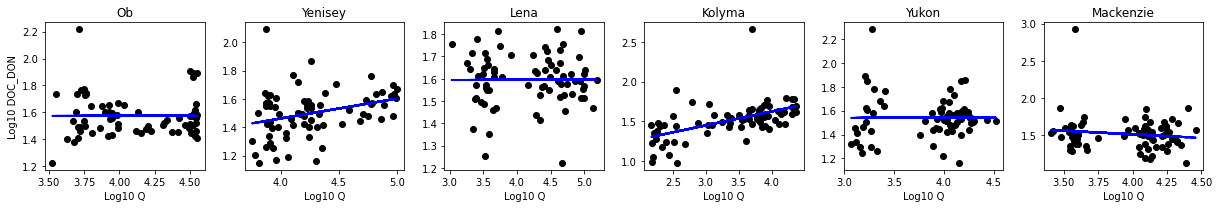

In [107]:
q_c_linear_regression(chem_q_daily_dict, 'DOC_DON', out_folder, log_chem=True, log_q=True)

# Use derived QC or CC relationships to predict C for the period 1980-2019

In [154]:
predicted_chem_dict = {}  # key: chem, returns df

for chem in chem_vars_cq:

    pred_li = []

    for river in rivers_li:

        # Get Q data
        q = q_dict[river]

        # Get regression result
        model = reg_dict_log[chem][river]
        alpha = alpha_df.loc[river, chem]

        # Q data to make predictions with
        q = q_dict[river].squeeze()
        log10q = np.log10(q)

        # Predict and back-transform from log scale with bias correcn
        pred = 10 ** (model.intercept_ + model.coef_ * log10q)
        pred = alpha * pred
        pred.name = river

        # Add to results
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_dict[chem] = pred_df

# Display example output
predicted_chem_dict['Alk']

,Ob,Yenisey,Lena,Kolyma,Yukon,Mackenzie
date,,,,,,
1980-01-01,83.675331,76.445195,68.798826,39.583559,122.105078,109.823909
1980-01-02,83.729467,76.684448,68.798826,39.522056,122.105078,109.432541
1980-01-03,83.729467,77.121130,68.937829,39.491669,122.105078,108.927742
1980-01-04,83.892526,77.317749,68.937829,39.461519,122.105078,108.621588
1980-01-05,84.056575,77.515959,68.937829,39.431604,122.105078,108.865951
...,...,...,...,...,...,...
2019-12-27,86.106144,65.748588,69.805701,33.740278,111.458114,100.490602
2019-12-28,86.284028,65.748588,69.805701,33.598727,111.806550,100.477707
2019-12-29,86.463056,65.454860,69.400510,33.581455,112.321440,100.468044


**To do:**
* Save predictions to file for those we want to use QC for
* Plot predictions and observations for quick check
* Repeat for vars to be calculated from chem instead of Q